In [ ]:
# Copyright (C) 2023 Elif Cansu YILDIZ
# 
# This program is free software; you can redistribute it and/or modify it under
# the terms of the GNU General Public License as published by the Free Software
# Foundation; either version 3 of the License, or (at your option) any later
# version.
# 
# This program is distributed in the hope that it will be useful, but WITHOUT
# ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
# FOR A PARTICULAR PURPOSE. See the GNU General Public License for more
# details.
# 
# You should have received a copy of the GNU General Public License along with
# this program; if not, see <http://www.gnu.org/licenses/>.

In [1]:
import torch
import numpy as np
import pandas as pd
from PIL import Image
import os
import yaml
import matplotlib.pyplot as plt

from medai.data.datasets import ChestXDetDataset
from medai.utils.chest_alignment import ChestAlignment
import medai.config as config
import medai.config as config

%load_ext autoreload
%autoreload 2

/home/cansu/ImprovingDiseaseDetectionBySymmetricFeatures/medai-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-14 13:11:14 stellaris torch.distributed.nn.jit.instantiator[972346] INFO Created a temporary directory at /tmp/tmpo9dwlg74
2023-07-14 13:11:14 stellaris torch.distributed.nn.jit.instantiator[972346] INFO Writing /tmp/tmpo9dwlg74/_remote_module_non_scriptable.py


In [2]:
config_file = "sasn_config.yaml"
config_file_path = os.path.join(config.CONFIG_DIR, config_file)
with open(config_file_path, "r") as stream:
    params = yaml.safe_load(stream)

params["dataset"]["train"]["transform"] = None

params["dataset"]["train"]["apply_alignment"] = False
dataset_wout_a = ChestXDetDataset(**params["dataset"]["train"])
params["dataset"]["train"]["apply_alignment"] = True
dataset_w_a = ChestXDetDataset(**params["dataset"]["train"])

In [3]:
import copy
def draw_center_vertical_line(img):
    img_c = copy.deepcopy(img)
    cols = img.shape[1]
    img_c[:,cols//2,:] = torch.Tensor([1.0, 0.0, 0.0])
    return img_c

In [4]:
idx = 1252
image, image_f, target = dataset_wout_a[idx]
image_a, image_f_a, target_a = dataset_w_a[idx]

target = torch.vstack((target,target,target))
target_a = torch.vstack((target_a,target_a,target_a))
print("Label: ", dataset_w_a.labels[idx])

Label:  ['No Finding']


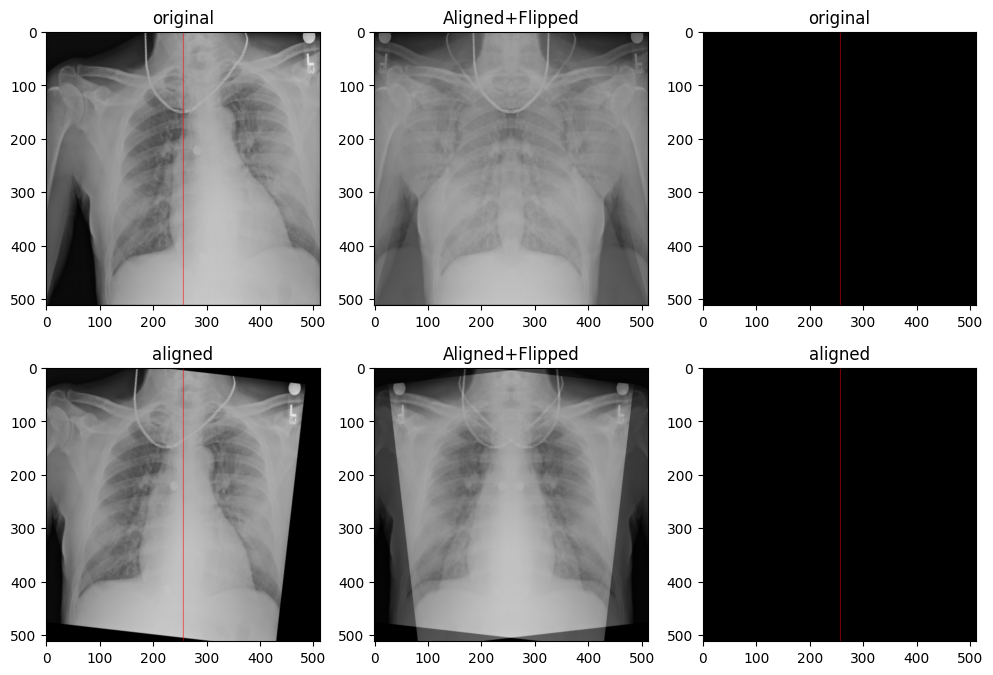

In [5]:
fig, axs = plt.subplots(2,3, figsize=(12,8))
axs[0,0].imshow(draw_center_vertical_line(image.permute(1,2,0))); axs[0,0].set_title("original")
axs[0,1].imshow(( image.permute(1,2,0) + torch.flip(image.permute(1,2,0), dims=[1]) )/2); axs[0,1].set_title("Aligned+Flipped")
axs[0,2].imshow(draw_center_vertical_line(target.permute(1,2,0))); axs[0,2].set_title("original")

axs[1,0].imshow(draw_center_vertical_line(image_a.detach().permute(1,2,0))); axs[1,0].set_title("aligned")
axs[1,1].imshow(( image_a.detach().permute(1,2,0) + torch.flip(image_a.detach().permute(1,2,0), dims=[1]) )/2); axs[1,1].set_title("Aligned+Flipped")
axs[1,2].imshow(draw_center_vertical_line(target_a.detach().permute(1,2,0))); _=axs[1,2].set_title("aligned")

In [6]:
#idx = 310
img_path = dataset_wout_a.image_file_paths[idx]
#print(img_path)

with Image.open(img_path) as image:
    img = np.array(image.convert('RGB'))/255
#img = torch.tensor(img, dtype=torch.float).permute(2,0,1).unsqueeze(0)

chest_alignment = ChestAlignment(use_gpu=False, n_trials=75)
output = chest_alignment.align_image(img)

Using cache found in /home/cansu/.cache/torch/hub/pytorch_vision_v0.10.0
/home/cansu/ImprovingDiseaseDetectionBySymmetricFeatures/medai-venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cansu/ImprovingDiseaseDetectionBySymmetricFeatures/medai-venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/cansu/ImprovingDiseaseDetectionBySymmetricFeatures/medai-venv/lib/python3.8/site-packages/optuna/samplers/_tpe/sampler.py:278: ExperimentalWarning: ``multivariate`` option is an experime

algorithm works better with n_trials>75


[I 2023-07-14 13:11:29,042] Trial 0 finished with value: 0.017819871434150054 and parameters: {'theta': -0.11131844576625974, 'scale': 0.9732870942969126, 'tx': 0.11223007516647321, 'ty': -0.0}. Best is trial 0 with value: 0.017819871434150054.
[I 2023-07-14 13:11:29,960] Trial 1 finished with value: 0.02037363904747693 and parameters: {'theta': -0.25961924605121683, 'scale': 1.036188190141479, 'tx': 0.034336782403999816, 'ty': -0.0}. Best is trial 0 with value: 0.017819871434150054.
[I 2023-07-14 13:11:30,890] Trial 2 finished with value: 0.021747094621507486 and parameters: {'theta': -0.19771835181460287, 'scale': 1.0310727815272924, 'tx': -0.008800855059581059, 'ty': -0.0}. Best is trial 0 with value: 0.017819871434150054.
[I 2023-07-14 13:11:31,817] Trial 3 finished with value: 0.025113007300587013 and parameters: {'theta': 0.2686614434249074, 'scale': 1.0414495381845317, 'tx': -0.07541480883456053, 'ty': -0.0}. Best is trial 0 with value: 0.017819871434150054.
[I 2023-07-14 13:11:

Best value: 0.012628765918008527 (params: {'theta': -0.1191968757846182, 'scale': 0.9678608664679177, 'tx': 0.19731761358355343, 'ty': -0.0})



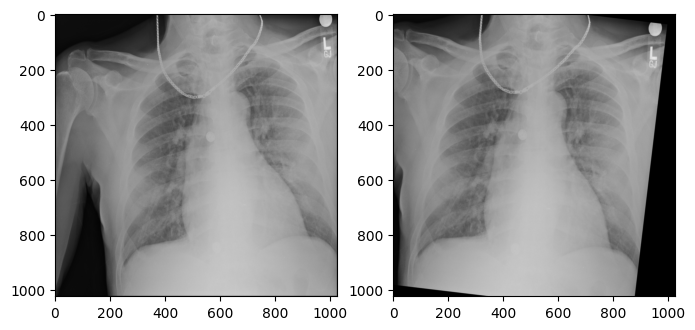

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
_ = axs[0].imshow(img)
_ = axs[1].imshow(output["aligned_image"])

## Loss Graphics of Alignment Parameters

Using cache found in /home/cansu/.cache/torch/hub/pytorch_vision_v0.10.0


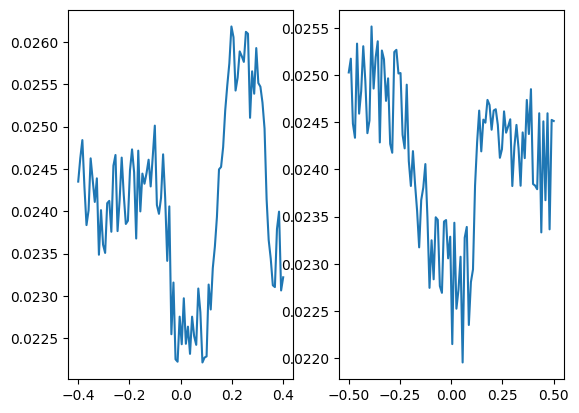

In [12]:
idx = 258
img_path = dataset_wout_a.image_file_paths[idx]
#print(img_path)

with Image.open(img_path) as image:
    img = np.array(image.convert('RGB'))/255
img_t = torch.tensor(img, dtype=torch.float).permute(2,0,1).unsqueeze(0)
img_t = img_t.float()

chest_alignment = ChestAlignment(use_gpu=False, n_trials=300)

txs = np.linspace(-0.4, 0.4, 100)
losses_tx = []
for tx in txs:
    #print(tx)
    loss = chest_alignment.compute_loss(img_t, scale=1.0, theta=0.0, tx=tx, ty=0.0)
    losses_tx.append(loss)
    
thetas = np.linspace(-0.5, 0.5, 100)
losses_theta = []
for theta in thetas:
    #print(theta)
    loss = chest_alignment.compute_loss(img_t, scale=1.0, theta=theta, tx=0.0, ty=0.0)
    losses_theta.append(loss)

fig, axs = plt.subplots(1,2)
_ = axs[0].plot(txs, losses_tx) 
_ = axs[1].plot(thetas, losses_theta)

In [9]:
theta_ = dataset_w_a.alignment_params[idx]["theta"]
scale_ = dataset_w_a.alignment_params[idx]["scale"]
tx_ = dataset_w_a.alignment_params[idx]["tx"]
ty_ = dataset_w_a.alignment_params[idx]["ty"]

#chest_alignment = ChestAlignment(use_gpu=False, n_trials=75)
loss = chest_alignment.compute_loss(img_t, scale_, theta_, tx_, ty_)
print(loss)

0.012791621872706051


## Visual Outputs

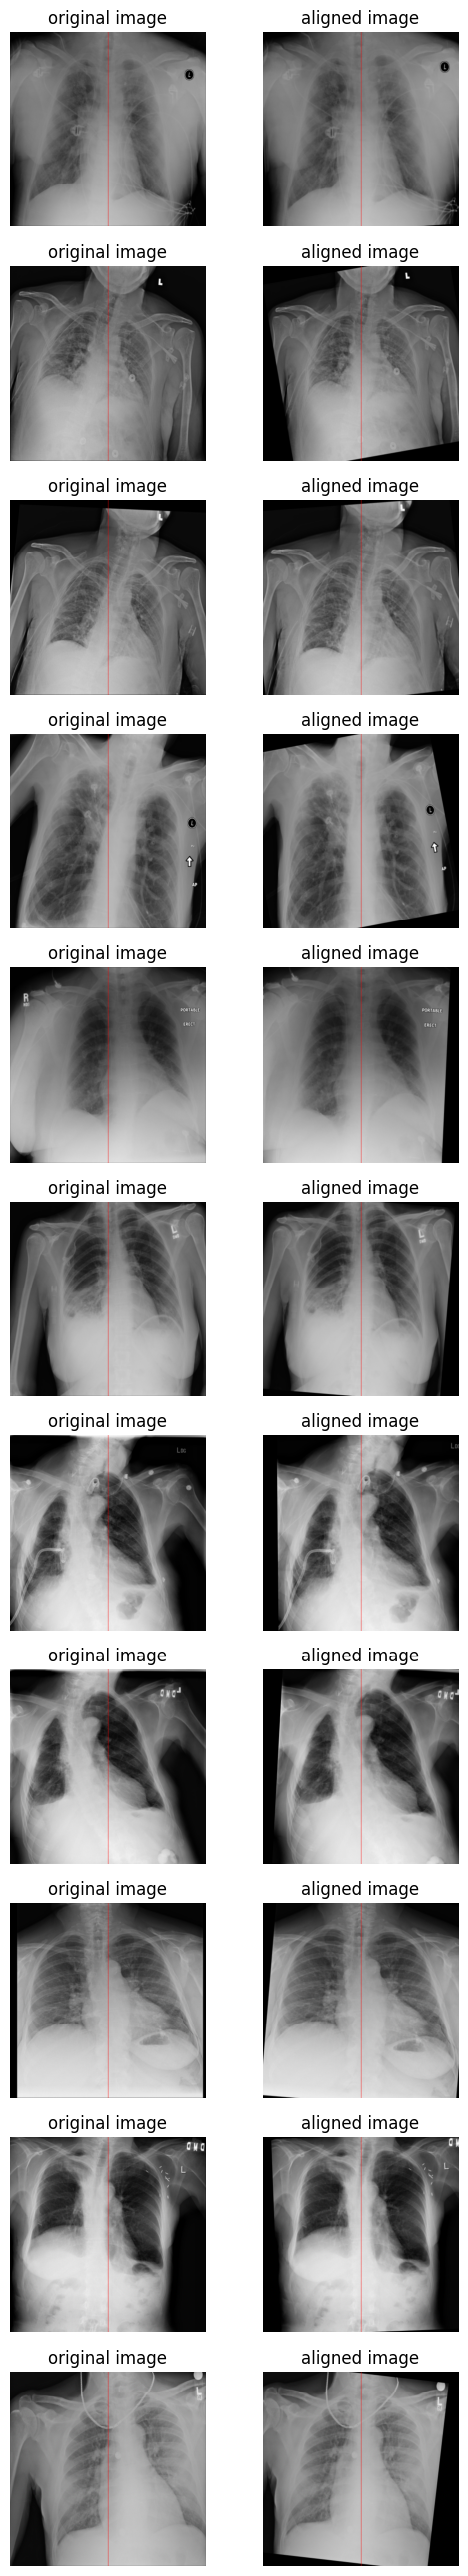

In [10]:
indexes = [340, 316, 315, 258, 193, 140, 124, 125, 112, 65, 1252]

fig, axs = plt.subplots(len(indexes), 2, figsize=(6, 3*len(indexes)))

for i, idx in enumerate(indexes):
    image, image_f, target = dataset_wout_a[idx]
    image_a, image_f_a, target_a = dataset_w_a[idx]

    target = torch.vstack((target,target,target))
    target_a = torch.vstack((target_a,target_a,target_a))

    #print(dataset_w_a.labels[idx])
    
    axs[i][0].imshow(draw_center_vertical_line(image.detach().permute(1,2,0))); axs[i][0].axis("off"); axs[i][0].set_title("original image")
    #plt.savefig(f"aligning_figures/{idx}.png",bbox_inches='tight')
    axs[i][1].imshow(draw_center_vertical_line(image_a.detach().permute(1,2,0))); _ = axs[i][1].axis("off"); axs[i][1].set_title("aligned image")
    #plt.savefig(f"aligning_figures/{idx}_a.png",bbox_inches='tight')

### Save original image and aligned image

Label:  ['Consolidation', 'Consolidation', 'Emphysema', 'Emphysema']


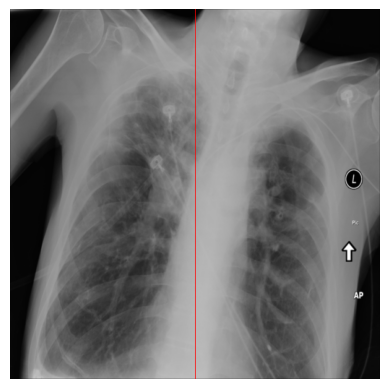

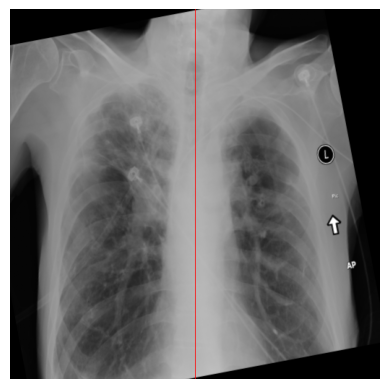

In [11]:
idx = 258
image, image_f, target = dataset_wout_a[idx]
image_a, image_f_a, target_a = dataset_w_a[idx]

target = torch.vstack((target,target,target))
target_a = torch.vstack((target_a,target_a,target_a))

print("Label: ", dataset_w_a.labels[idx])

_ = plt.imshow(draw_center_vertical_line(image.detach().permute(1,2,0))); plt.axis("off")
_ = plt.savefig(f"{idx}.png", bbox_inches='tight')
_ = plt.show()
_ = plt.imshow(draw_center_vertical_line(image_a.detach().permute(1,2,0))); plt.axis("off")
_ = plt.savefig(f"{idx}_a.png", bbox_inches='tight')
_ = plt.show()